## Data Collection

In [2]:
import praw
import pandas as pd

# Reddit API authentication
reddit = praw.Reddit(
    client_id="pzesY9KJ5dirnPGFkQ6QFA",
    client_secret="cKHT4uAr-lWdMj4efLhIe6mHXLBh5g",
    user_agent="trend analysis"
)

# Collect posts
posts = []
for submission in reddit.subreddit("technology").hot(limit=400):
    posts.append({
        "title": submission.title,
        "text": submission.selftext
    })

df = pd.DataFrame(posts)
df.to_csv("reddit_posts.csv", index=False)
df.head()


,title,text
0,Reddit will block the Internet Archive,
1,Grok claims it was briefly suspended from X af...,
2,"If You Try to Sell Your Cybertruck, You Are Go...",
3,"Trump flip-flops on Intel CEO, calls him 'succ...",
4,Reddit Is Blocking the Wayback Machine From Ar...,


In [6]:
df.shape

(400, 2)

## Data Cleaning

In [3]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

df = pd.read_csv("reddit_posts.csv")
df["text"] = (df["title"].fillna('') + " " + df["text"].fillna(''))

# Clean text
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df["clean_text"] = df["text"].apply(clean_text)
df.to_csv("cleaned_posts.csv", index=False)
df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\atusi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,text,clean_text
0,Reddit will block the Internet Archive,Reddit will block the Internet Archive,reddit block internet archive
1,Grok claims it was briefly suspended from X af...,Grok claims it was briefly suspended from X af...,grok claims briefly suspended x accusing israe...
2,"If You Try to Sell Your Cybertruck, You Are Go...","If You Try to Sell Your Cybertruck, You Are Go...",try sell cybertruck going get terrible surprise
3,"Trump flip-flops on Intel CEO, calls him 'succ...","Trump flip-flops on Intel CEO, calls him 'succ...",trump flipflops intel ceo calls success days d...
4,Reddit Is Blocking the Wayback Machine From Ar...,Reddit Is Blocking the Wayback Machine From Ar...,reddit blocking wayback machine archiving post...


## Clustering Analysis

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

df = pd.read_csv("cleaned_posts.csv")

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["clean_text"])

kmeans = KMeans(n_clusters=5, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

df[["clean_text", "cluster"]].head()
df.to_csv("clustered_posts.csv", index=False)

In [9]:
df = pd.read_csv("clustered_posts.csv")
df['cluster'].unique()


array([2, 4, 3, 1, 0])

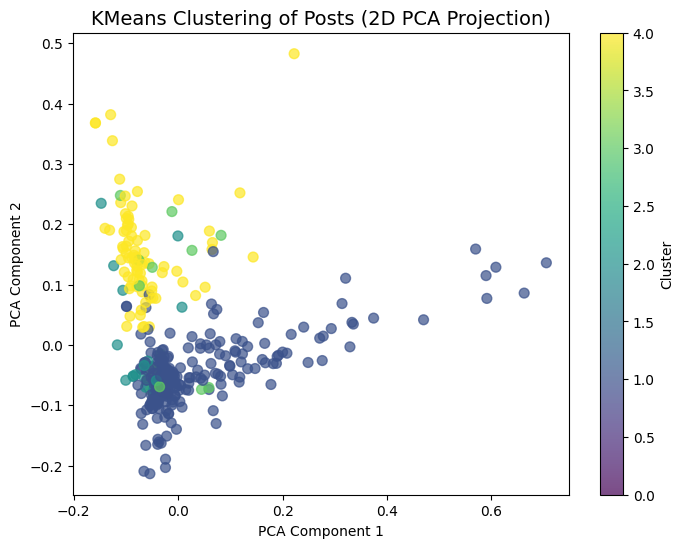

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce TF-IDF features to 2D using PCA
pca = PCA(n_components=2, random_state=42)
reduced_X = pca.fit_transform(X.toarray())

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df["cluster"], cmap='viridis', s=50, alpha=0.7)

# Labeling
plt.title("KMeans Clustering of Posts (2D PCA Projection)", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()


## Classification Model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

df = pd.read_csv("clustered_posts.csv")

df["trending"] = df["cluster"].apply(lambda x: 1 if x in [0,1] else 0)

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["clean_text"])
y = df["trending"]

# Handle imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))



Train Accuracy: 0.9934354485776805
Test Accuracy: 0.9739130434782609
